In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import networkx as nx
from pomegranate import * 
from sklearn.model_selection import train_test_split

네트워크 시각화

In [22]:
def draw_graph(df, model):
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    from matplotlib import rc
    import networkx as nx
        
    # 한글 설정
    font_paths = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    path = 'C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf'
    font_name = fm.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name, size=30)
    
    # 그래프 구조 및 노드/엣지 정의
    ar = df.to_numpy()
    nodes = df.columns.tolist()
    structure = model.structure
    print('structure:', structure)
    print("P(D|M): ", model.log_probability(ar).sum())
    
    edges = []
    for i in range(len(nodes)):
        try:
            for j in range(len(structure[i])):
                edges.append((nodes[structure[i][j]], nodes[i]))
        except IndexError:
            pass



    # NetworkX 그래프 생성
    g = nx.DiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    # 
    fig = plt.figure(figsize=(10, 8))
    pos = nx.circular_layout(g)
    nx.draw(g, with_labels=True,font_family=font_name, edge_color='gray', node_size=1000, node_color='lightsalmon'\
           , cmap=plt.cm.Blues, font_size=15)
    

조건부확률 계산

In [3]:
def get_conditional_prob(df, child, parent1=None, parent2=None):
    p_list=[]
    if parent1==None:
        #print('no parent')
        
        child_values = df[child].unique()

        idx = df[child].value_counts(normalize=True).index
        p = df[child].value_counts(normalize=True).values
        p_list += [[i,j] for i,j in zip(idx,p)]
        for childv in child_values:
            if childv not in idx:
                p_list += [childv,0]
                
        p_list_dic = {}
        for i in p_list:
            p_list_dic[i[0]]=i[-1]
        p_list=p_list_dic


    elif (parent1!=None) and (parent2==None):
        #print('parent1')
        
        child_values = df[child].unique()
        parent1_values = df[parent1].unique()

        for par1 in parent1_values:
            idx = df[df[parent1]==par1][child].value_counts(normalize=True).index
            p = df[df[parent1]==par1][child].value_counts(normalize=True).values
            p_list += [[par1,childv,p] for childv,p in zip(idx,p)]
            #0일 땐 value_counts에 포함이 안되어서 따로 넣어줌
            for childv in child_values:
                if childv not in idx:
                    p_list += [[par1, childv, 0]]

            #parent_value별 조건부확률 누적 값은 1이 되어야 함
            #print(sum(p))

    elif (parent1!=None) and (parent2!=None):  
        #print('parent2')
        
        child_values = df[child].unique()
        parent1_values = df[parent1].unique()
        parent2_values = df[parent2].unique()

        for par1 in parent1_values:
            for par2 in parent2_values:
                
                idx = df[(df[parent1]==par1) & (df[parent2]==par2)][child].value_counts(normalize=True).index
                p = df[(df[parent1]==par1) & (df[parent2]==par2)][child].value_counts(normalize=True).values
                p_list += [[par1,par2,childv,p] for childv,p in zip(idx,p)]

                #0일 땐 value_counts에 포함이 안되어서 따로 넣어줌
                for childv in child_values:
                    if childv not in idx:
                        p_list += [[par1, par2, childv,0]]
                #parent_value별 조건부확률 누적 값은 1이 되어야 함
                #print(sum(p))
    
    return p_list

    
    

## 모델 생성

In [101]:
def make_BN(df, method, model_name):
    
    #구조학습을 위해 데이터프레임을 어레이로 변환
    ar = df.to_numpy()

    # 모델 구조 학습
    model_structure = BayesianNetwork.from_samples(ar, algorithm=method)
    structure = model_structure.structure
    #print(structure)
    
    # 학습된 모델을 바탕으로 노드리스트, 엣지리스트 정의
    nodes = df.columns.tolist()
    #print(nodes)
    
    edges = []
    for i in range(len(nodes)):
        try:
            for j in range(len(structure[i])):
                edges.append((nodes[structure[i][j]], nodes[i]))
        except IndexError:
            pass
    #print(edges)
    
    # 각 노드의 확률(조건부확률) 정의
    prob_dic = {}
    for i in range(len(nodes)):

        child = nodes[i]
        parent = [nodes[j] for j in structure[i]]

        prob_dic[child] = {}
        prob_dic[child]['parent'] = parent    

        if len(parent) == 0:
            prob_dic[child]['probability'] = get_conditional_prob(train_set, child)

        elif len(parent) == 1:
            prob_dic[child]['probability'] = get_conditional_prob(train_set, child, parent1=parent[0])

        elif len(parent) == 2:
            prob_dic[child]['probability'] = get_conditional_prob(train_set, child, parent1=parent[0], parent2=parent[1])


    # 노드를 담을 딕셔너리
    node_dic = {}

    # 독립인 변수들부터 노드 만들기 (first layer)
    for i in range(len(nodes)):  
        child = nodes[i]
        parent = [nodes[j] for j in structure[i]]

        if len(parent) == 0:
            node_dic[child] = Node(
                DiscreteDistribution(prob_dic[child]['probability']),
                name = child
            )


    # 만들어진 노드들의 child 순차적으로 만들기 (second layer)
    # 모든 노드들이 다 포함될 때 까지 진행
    while len(node_dic) < len(nodes):
        parent_nodes = list(node_dic.keys())
        for parent in parent_nodes:

            #edge[0]: parent, edge[1]: child
            for edge in edges:
                if parent == edge[0]:
                    #print(edge[1])

                    child = edge[1]
                    parent = edge[0]

                    node_dic[child] = Node(
                        ConditionalProbabilityTable(
                            prob_dic[child]['probability'] , 
                            [node_dic[parent].distribution]
                        )
                        , name=child
                    )
    
    # 최종 모델 생성
    
    model = BayesianNetwork(model_name)
    
    for node in nodes:
        model.add_states(node_dic[node])
        
    for edge in edges:
        parent = edge[0]
        child = edge[1]
        model.add_edge(node_dic[parent], node_dic[child])
    
    model.bake()
    
    return model



# 와인 데이터

## 데이터 불러오기

In [102]:
df = pd.read_csv('./Data/wine.csv')
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [103]:
model1 = make_BN(train_set, 'exact','wine_exact')
model2 = make_BN(train_set, 'exact-dp', 'wine_exact-dp')
#model3 = make_BN(train_set, 'greedy', 'wine_greedy') ### seperated component 때문에 안되는 것 같음.. 
model4 = make_BN(train_set, 'chow-liu', 'wine_chow-liu')

### 어떻게 모델별로 결과가 같음????

In [51]:
model_list = [model1, model2, model4]
false_index_list = []
predicted_values = []

for model in model_list:
    n=0
    print(n)
    false_index = []
    ppp = []
    nodes = test_set.columns.to_list()

    for i in test_set.index:
        try:
            data = dict(test_set.loc[i])
            
            #예측하고자 하는 변수
            target = 'quality'
            actual_value = data[target]
            #print(actual_value)

            data[target]=None 
            predicted_value = model.predict([list(data.values())])[0][nodes.index(target)]
            #print(predicted_value)

            if actual_value == predicted_value:
                n+=1
            else:
                false_index.append(i)
                ppp.append(predicted_value)
        except ValueError:
            pass
    
    false_index_list.append(false_index)
    predicted_values.append(ppp)
    print("structure:", model.structure)
    print("accuracy for '", model.name,"':", n/len(test_set))
    print()

0
structure: ((8,), (), (0,), (7,), (), (6,), (10,), (10,), (10,), (10,), (11,), (1,))
accuracy for ' wine_exact ': 0.49795918367346936

0
structure: ((8,), (11,), (0,), (7,), (), (6,), (10,), (10,), (10,), (10,), (), (10,))
accuracy for ' wine_exact-dp ': 0.49795918367346936

0
structure: ((), (11,), (0,), (7,), (10,), (6,), (10,), (10,), (0,), (10,), (8,), (10,))
accuracy for ' wine_chow-liu ': 0.49795918367346936



In [83]:
X = numpy.random.randint(2, size=(200, 15))

In [100]:
import networkx
from pomegranate.utils import plot_networkx

constraints = networkx.DiGraph()
constraints.add_edge('genetic conditions', 'diseases')
constraints.add_edge('diseases', 'symptoms')
plot_networkx(constraints)

ModuleNotFoundError: No module named 'pygraphviz'

In [98]:
df

,fixedacidity,volatileacidity,citricacid,residualsugar,chlorides,freesulfurdioxide,totalsulfurdioxide,density,ph,sulphates,alcohol,quality
0,2,1,2,2,1,1,2,2,2,2,1,bad
1,2,2,2,1,1,1,2,1,3,2,2,bad
2,3,1,2,1,1,1,2,1,3,2,2,bad
3,2,1,1,1,1,1,3,1,3,2,2,bad
4,2,1,1,1,1,1,3,1,3,2,2,bad
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,2,1,1,1,1,1,1,1,3,2,3,bad
4894,2,2,2,1,1,1,2,1,2,2,2,NaN
4895,2,1,1,1,1,1,2,1,2,2,2,bad
4896,1,2,1,1,1,1,2,1,3,1,4,bad


In [97]:
prob_list

NameError: name 'prob_list' is not defined

structure: ((), (11,), (0,), (7,), (10,), (6,), (10,), (10,), (0,), (10,), (8,), (10,))
P(D|M):  -33130.90050934095


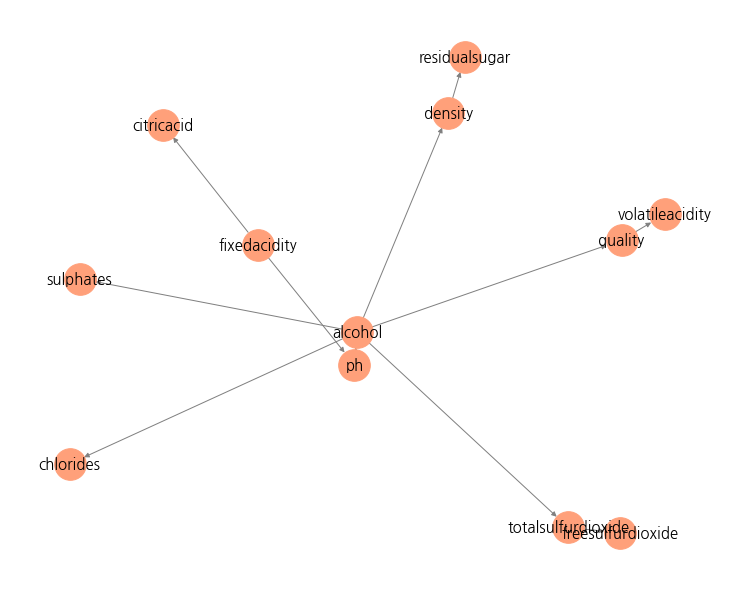

In [42]:
draw_graph(train_set, model4)

structure: ((8,), (11,), (0,), (7,), (), (6,), (10,), (10,), (10,), (10,), (), (10,))
P(D|M):  -33186.307983791594


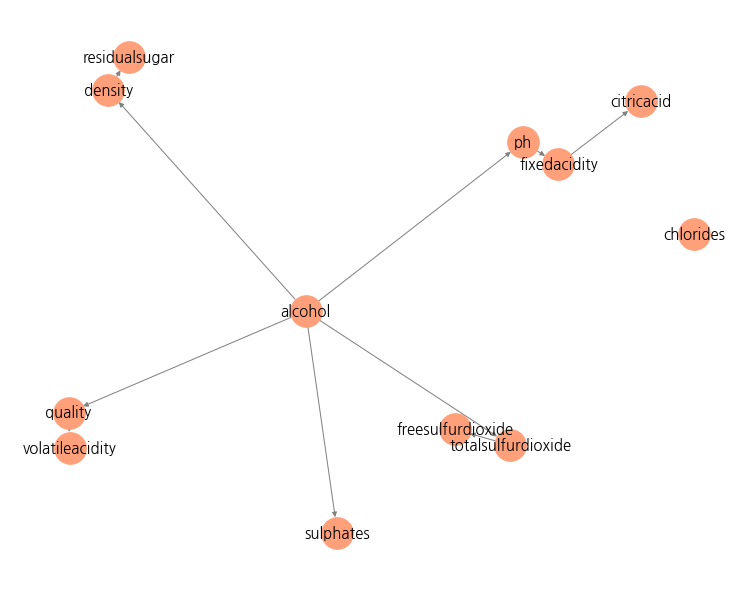

In [46]:
draw_graph(train_set, model2)

In [61]:
for i in np.corrcoef(train_set):
    print(i)

[1.         0.57894077 0.69193919 ... 0.96490128 0.72786026 0.63862963]
[0.57894077 1.         0.40761973 ... 0.68       0.59186403 0.60783067]
[0.69193919 0.40761973 1.         ... 0.67936622 0.70957488 0.60564479]
[0.85988668 0.69611792 0.78819833 ... 0.93824589 0.81663822 0.88916905]
[0.27994626 0.52223297 0.5913124  ... 0.31333978 0.63636364 0.40207701]
[0.64517917 0.55549206 0.73379939 ... 0.74065608 0.64465837 0.82535472]
[0.83983877 0.59186403 0.70957488 ... 0.87038828 0.63636364 0.78299207]
[0.77440309 0.50562058 0.8996469  ... 0.79454663 0.69156407 0.7171073 ]
[0.35161528 0.53099079 0.31829754 ... 0.53099079 0.46216816 0.77840306]
[0.63186405 0.57035183 0.81800861 ... 0.72244565 0.7611889  0.87054531]
[0.83562902 0.69282032 0.78446454 ... 0.92376043 0.70352647 0.91242113]
[0.89655172 0.57894077 0.69193919 ... 0.96490128 0.72786026 0.87322827]
[0.21971769 0.64409405 0.26519742 ... 0.40987803 0.15289416 0.62877292]
[0.60438685 0.85687647 0.6638358  ... 0.67648143 0.74581524 0.70

[0.41289246 0.77024089 0.41710377 ... 0.50233101 0.55381584 0.5767386 ]
[0.09007547 0.42008403 0.1902606  ... 0.25205042 0.36563621 0.52770258]
[0.1119785  0.10444659 0.23652496 ... 0.10444659 0.09090909 0.14813363]
[0.03138824 0.40987803 0.06629935 ... 0.17566201 0.35675303 0.48640924]
[0.85392282 0.53099079 0.63659507 ... 0.90580782 0.78840451 0.77840306]
[0.71919495 0.62609903 0.60764362 ... 0.80498447 0.85634884 0.81549042]
[0.86303394 0.35777088 0.91146543 ... 0.80498447 0.77849894 0.59802631]
[0.49541508 0.92418486 0.47565149 ... 0.58811764 0.5118907  0.52770258]
[0.25492496 0.27174649 0.30769231 ... 0.40761973 0.5913124  0.68823271]
[0.91025899 0.64409405 0.82874193 ... 0.87831007 0.76447079 0.58131836]
[0.13130643 0.48989795 0.2773501  ... 0.32659863 0.28426762 0.69480833]
[0.95723234 0.69611792 0.78819833 ... 0.93824589 0.81663822 0.66840983]
[0.65299981 0.40605178 0.42439671 ... 0.78086881 0.35342271 0.85434483]
[0.81609427 0.52698604 0.7292929  ... 0.87831007 0.66254135 0.86

[0.25492496 0.13587324 0.19230769 ... 0.40761973 0.35478744 0.68823271]
[0.30518138 0.50233101 0.18959262 ... 0.50233101 0.43722303 0.73958244]
[0.92802366 0.37870125 0.76570486 ... 0.91970303 0.70632241 0.7344037 ]
[0.81889175 0.49194631 0.67428678 ... 0.90621689 0.6986165  0.88656824]
[0.85988668 0.57505393 0.78819833 ... 0.8171819  0.81663822 0.52123703]
[0.8800091  0.41736501 0.72461164 ... 0.86255435 0.75075719 0.6144869 ]
[0.5336001  0.76120206 0.7292929  ... 0.64409405 0.66254135 0.79486388]
[0.87645659 0.41825801 0.81800861 ... 0.87453947 0.7611889  0.77809802]
[0.63186405 0.57035183 0.81800861 ... 0.72244565 0.7611889  0.87054531]
[0.5560359  0.76667895 0.71490009 ... 0.5862839  0.82432211 0.50256086]
[0.37139068 0.80829038 0.19611614 ... 0.57735027 0.30151134 0.77204865]
[0.49629167 0.74065608 0.73379939 ... 0.55549206 0.64465837 0.60025798]
[0.83624778 0.52       0.81523946 ... 0.84       0.73112616 0.70508358]
[0.60438685 0.31569133 0.51064292 ... 0.49608638 0.27477404 0.15

[0.19298026 0.68       0.40761973 ... 0.36       0.17407766 0.60783067]
[0.50295259 0.57505393 0.85673731 ... 0.57505393 0.71126555 0.69293864]
[0.39003823 0.63059263 0.32954102 ... 0.43656413 0.3799803  0.38329354]
[0.37139068 0.57735027 0.39223227 ... 0.34641016 0.30151134 0.21055872]
[0.69193919 0.40761973 0.88461538 ... 0.67936622 0.82783735 0.60564479]
[0.83569117 0.72244565 0.8610617  ... 0.87453947 0.7611889  0.74728225]
[0.69193919 0.40761973 1.         ... 0.67936622 0.70957488 0.60564479]
[0.16609096 0.77459667 0.35082321 ... 0.30983867 0.40451992 0.50221186]
[0.72192954 0.52698604 0.62984387 ... 0.76120206 0.45868247 0.72368204]
[0.72192954 0.76120206 0.82874193 ... 0.76120206 0.86640023 0.72368204]
[0.52522573 0.73484692 0.79738153 ... 0.61237244 0.74620251 0.69480833]
[0.50295259 0.75664991 0.4455034  ... 0.63558592 0.34246119 0.72973184]
[ 0.2109156  -0.030266    0.4455034  ...  0.09079799  0.18440218
 -0.11651181]
[0.81609427 0.52698604 0.82874193 ... 0.76120206 0.764470

[0.4068381  0.88543774 0.53708616 ... 0.50596443 0.44038551 0.53819622]
[0.14267898 0.41825801 0.43053085 ... 0.11407037 0.36404687 0.0385197 ]
[0.46880236 0.57035183 0.47358393 ... 0.57035183 0.49642754 0.65483496]
[0.72192954 0.76120206 0.82874193 ... 0.76120206 0.86640023 0.72368204]
[0.91025899 0.64409405 0.82874193 ... 0.87831007 0.86640023 0.6525002 ]
[0.83983877 0.73112616 0.70957488 ... 0.87038828 0.87878788 0.69834428]
[0.14267898 0.72244565 0.30137159 ... 0.26616419 0.49642754 0.40830886]
[0.78550702 0.15158735 0.71516196 ... 0.75793673 0.48377945 0.62450064]
[0.6642183  0.36837608 0.94796312 ... 0.63628595 0.78700145 0.52245732]
[0.54605352 0.82462113 0.32954102 ... 0.63059263 0.3799803  0.50123001]
[0.19298026 0.52       0.13587324 ... 0.36       0.45260191 0.60783067]
[0.26497525 0.57035183 0.43053085 ... 0.41825801 0.7611889  0.68565073]
[0.459334   0.5862839  0.6638358  ... 0.5862839  0.51029464 0.75841003]
[0.89056356 0.79454663 0.77696778 ... 0.93900965 0.817303   0.80

[0.73561463 0.6990816  0.85018767 ... 0.80264924 0.87890462 0.82361665]
[0.90216888 0.59551396 0.85018767 ... 0.90621689 0.87890462 0.76066506]
[0.66272276 0.67434178 0.82717019 ... 0.67434178 0.88040878 0.56928558]
[0.83624778 0.52       0.67936622 ... 0.84       0.73112616 0.60783067]
[0.70108874 0.31569133 0.71490009 ... 0.67648143 0.74581524 0.55738568]
[0.72786026 0.45260191 0.47304992 ... 0.73112616 0.75757576 0.61369649]
[0.59637658 0.64409405 0.66299354 ... 0.64409405 0.56061191 0.62877292]
[0.72192954 0.76120206 0.82874193 ... 0.76120206 0.86640023 0.72368204]
[0.5678497  0.69611792 0.58258137 ... 0.69611792 0.39514753 0.81558264]
[0.49629167 0.74065608 0.57655666 ... 0.55549206 0.64465837 0.60025798]
[0.35161528 0.5934603  0.53049589 ... 0.46852129 0.40779544 0.66449042]
[0.36393013 0.73112616 0.68000926 ... 0.41778637 0.63636364 0.46556285]
[0.79502872 0.60783067 0.93599649 ... 0.80233649 0.86763986 0.7044335 ]
[0.72367596 0.6        0.93412855 ... 0.7        0.69631062 0.54

[0.61588176 0.87038828 0.5913124  ... 0.73112616 0.75757576 0.78299207]
[0.60438685 0.85687647 0.51064292 ... 0.67648143 0.74581524 0.59393557]
[0.84102145 0.4869016  0.85758945 ... 0.81150267 0.70632241 0.6686362 ]
[0.37315837 0.57505393 0.78819833 ... 0.45398995 0.60589288 0.59482343]
[0.79111445 0.35777088 0.91146543 ... 0.80498447 0.77849894 0.7611244 ]
[0.60438685 0.67648143 0.51064292 ... 0.67648143 0.43178777 0.70358521]
[0.3939193  0.65319726 0.41602515 ... 0.48989795 0.28426762 0.59555   ]
[0.76564149 0.75615125 0.76104239 ... 0.75615125 0.65814518 0.52770258]
[0.4152274  0.464758   0.0877058  ... 0.464758   0.40451992 0.40804713]
[0.59109863 0.87453947 0.47358393 ... 0.72244565 0.62880822 0.74728225]
[0.84102145 0.37870125 0.76570486 ... 0.81150267 0.80049874 0.60286871]
[0.91025899 0.52698604 0.82874193 ... 0.87831007 0.76447079 0.6525002 ]
[0.28767798 0.80498447 0.45573272 ... 0.4472136  0.54494926 0.70675837]
[0.61588176 0.87038828 0.5913124  ... 0.73112616 0.75757576 0.78

[0.19298026 0.52       0.13587324 ... 0.36       0.45260191 0.60783067]
[0.30976124 0.65008361 0.53160953 ... 0.36115756 0.44008623 0.36587107]
[0.83624778 0.52       0.67936622 ... 0.84       0.73112616 0.70508358]
[0.77440309 0.50562058 0.65428866 ... 0.79454663 0.69156407 0.7171073 ]
[0.89056356 0.79454663 0.77696778 ... 0.93900965 0.817303   0.80491636]
[0.30976124 0.65008361 0.53160953 ... 0.36115756 0.69156407 0.45368013]
[0.66436384 0.77459667 0.48238191 ... 0.77459667 0.67419986 0.78470603]
[0.5299764  0.57480125 0.57273414 ... 0.66676945 0.34020418 0.83385797]
[0.60783067 0.52915026 0.77032889 ... 0.68033605 0.8553372  0.78111056]
[0.71196668 0.75894664 0.85933785 ... 0.75894664 0.77067464 0.69196657]
[0.21971769 0.52698604 0.06629935 ... 0.29277002 0.05096472 0.27286372]
[0.32163376 0.36       0.67936622 ... 0.36       0.31333978 0.51057777]
[0.85392282 0.53099079 0.74269425 ... 0.90580782 0.78840451 0.85434483]
[0.77364214 0.53452248 0.63548891 ... 0.85523597 0.46524211 0.84

In [62]:
result = np.corrcoef(train_set)

In [65]:
len(result)

3918

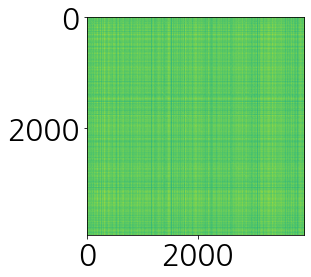

In [63]:
plt.imshow(result)

In [64]:
len(train_set)

3918

In [56]:
df.columns

Index(['fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar',
       'chlorides', 'freesulfurdioxide', 'totalsulfurdioxide', 'density', 'ph',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

# 해상사고 데이터

## 데이터 불러오기

In [104]:
df = pd.read_csv('./Data/해양경찰청_해상조난사고_상세데이터_현황_20191231.csv', encoding='euckr')
df.rename(columns={'선 종':'선종'},inplace=True)
df = df[['발생일시','관할해경서','발생해역','기상상태','발생원인','발생유형','선종']]
df = df.drop_duplicates()
df['사고월']=df['발생일시'].apply(lambda x: 'January' if x.split('-')[1]=='01' \
                                    else 'February' if x.split('-')[1]=='02'\
                                    else 'March' if x.split('-')[1]=='03'\
                                    else 'April' if x.split('-')[1]=='04'\
                                    else 'May' if x.split('-')[1]=='05'\
                                    else 'June' if x.split('-')[1]=='06'\
                                    else 'July' if x.split('-')[1]=='07'\
                                    else 'August' if x.split('-')[1]=='08'\
                                    else 'September' if x.split('-')[1]=='09'\
                                    else 'October' if x.split('-')[1]=='10'\
                                    else 'November' if x.split('-')[1]=='11'\
                                    else 'December' if x.split('-')[1]=='12'\
                                    else 'etc'
                           )

df = df[['관할해경서','발생해역','기상상태','발생원인','발생유형','선종','사고월']]

# train set, test set split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=15)

In [25]:
model1, prob_dic1, node_dic1 = make_BN(train_set, 'exact', 'marine_exact')
model2, prob_dic2, node_dic2 = make_BN(train_set, 'exact-dp', 'marine_exact-dp')
model3, prob_dic3, node_dic3 = make_BN(train_set, 'greedy', 'marine_greedy') 
model4, prob_dic4, node_dic4 = make_BN(train_set, 'chow-liu', 'marine_chow-liu')

((1,), (3,), (), (), (3,), (), ())
['관할해경서', '발생해역', '기상상태', '발생원인', '발생유형', '선종', '사고월']
[('발생해역', '관할해경서'), ('발생원인', '발생해역'), ('발생원인', '발생유형')]
((1,), (3,), (), (), (3,), (), ())
['관할해경서', '발생해역', '기상상태', '발생원인', '발생유형', '선종', '사고월']
[('발생해역', '관할해경서'), ('발생원인', '발생해역'), ('발생원인', '발생유형')]
((1,), (), (), (1,), (3,), (), ())
['관할해경서', '발생해역', '기상상태', '발생원인', '발생유형', '선종', '사고월']
[('발생해역', '관할해경서'), ('발생해역', '발생원인'), ('발생원인', '발생유형')]
((), (0,), (0,), (4,), (5,), (0,), (0,))
['관할해경서', '발생해역', '기상상태', '발생원인', '발생유형', '선종', '사고월']
[('관할해경서', '발생해역'), ('관할해경서', '기상상태'), ('발생유형', '발생원인'), ('선종', '발생유형'), ('관할해경서', '선종'), ('관할해경서', '사고월')]


In [29]:
node_dic1

{'기상상태': {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "str",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "\uc591\ud638" : 0.9012388162422574,
                 "\uc800\uc2dc\uc815" : 0.024432209222298693,
                 "\ud48d\ub791\uc8fc\uc758\ubcf4" : 0.02339986235375086,
                 "\ud0dc\ud48d\uacbd\ubcf4" : 0.015829318651066758,
                 "\ud669\ucc9c5\uae09" : 0.014796971782518927,
                 "\ud669\ucc9c6\uae09" : 0.011011699931176875,
                 "\ud669\ucc9c4\uae09" : 0.004473503097040606,
                 "\ud0dc\ud48d\uc8fc\uc758\ubcf4" : 0.0024088093599449415,
                 "\ud48d\ub791\uacbd\ubcf4" : 0.0024088093599449415
             }
         ],
         "frozen" : false
     },
     "name" : "\uae30\uc0c1\uc0c1\ud0dc",
     "weight" : 1.0
 },
 '발생원인': {
     "class" : "State",
     "distribution" : {
         "class" : "Di

In [30]:
node_dic3

{'발생해역': {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "str",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "\uc601\ud574" : 0.5498967653131452,
                 "\ud56d\uacc4 \ub0b4" : 0.3055746730901583,
                 "\ud611\uc218\ub85c" : 0.06641431520991053,
                 "\uc601\ud574-EEZ" : 0.06262904335856848,
                 "\uacf5\ud574" : 0.012044046799724708,
                 "EEZ-30\ub9c8\uc77c \uc774\ub0b4" : 0.0034411562284927736
             }
         ],
         "frozen" : false
     },
     "name" : "\ubc1c\uc0dd\ud574\uc5ed",
     "weight" : 1.0
 },
 '기상상태': {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "str",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "\uc591\ud638" : 0.9012388162422574,
                 "\uc800\uc2dc\uc815" : 0.02443

structure: ((1,), (3,), (), (), (3,), (), ())
P(D|M):  -32586.421544036937


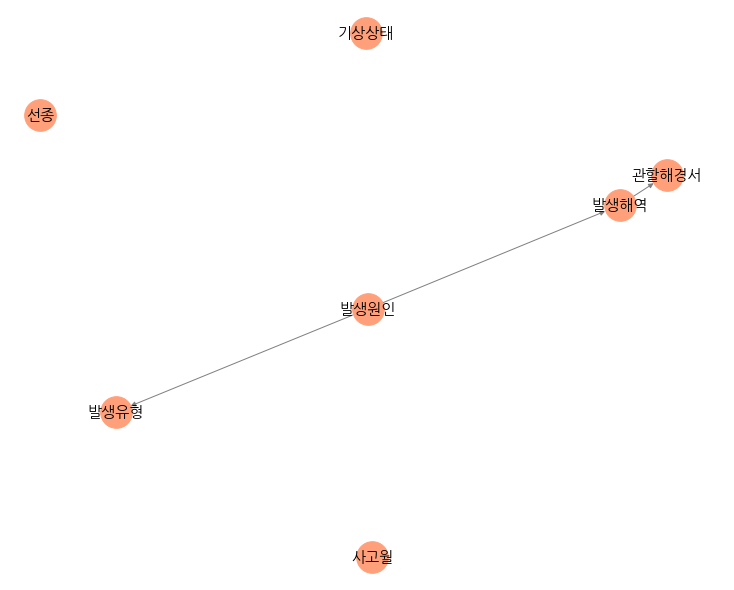

In [31]:
draw_graph(train_set, model1)

structure: ((), (0,), (0,), (4,), (5,), (0,), (0,))
P(D|M):  -31345.19538440318


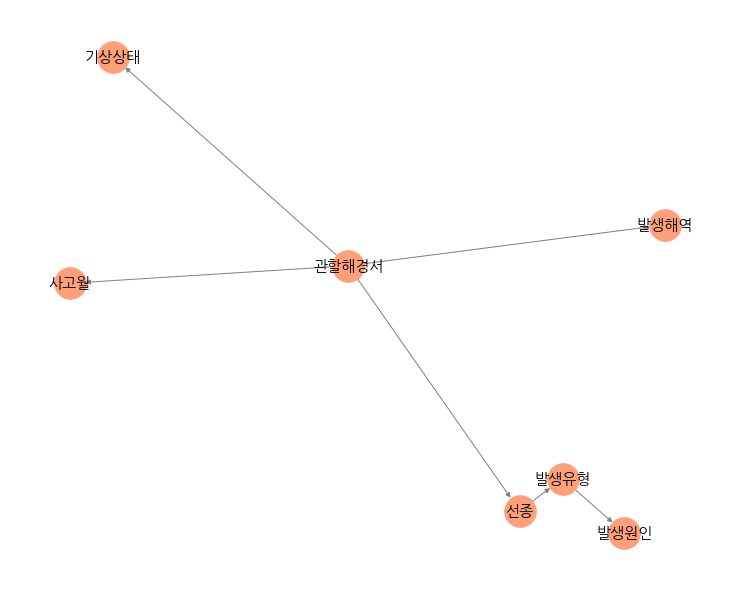

In [27]:
draw_graph(train_set, model4)

In [28]:
model_list = [model1, model2, model3, model4]
false_index_list = []

for model in model_list:
    n=0
    print(n)
    false_index = []
    nodes = test_set.columns.to_list()

    for i in test_set.index:
        try:
            data = dict(test_set.loc[i])
            
            #예측하고자 하는 변수
            target = '발생원인'
            actual_value = data[target]
            #print(actual_value)

            data[target]=None 
            predicted_value = model.predict([list(data.values())])[0][nodes.index(target)]
            #print(predicted_value)

            if actual_value == predicted_value:
                n+=1
            else:
                false_index.append(i)
        except ValueError:
            pass
    
    false_index_list.append(false_index)
    print("structure:", model.structure)
    print("accuracy for '", model.name,"':", n/len(test_set))
    print()

0
structure: ((1,), (3,), (), (), (3,), (), ())
accuracy for ' marine_exact ': 0.811554332874828

0
structure: ((1,), (3,), (), (), (3,), (), ())
accuracy for ' marine_exact-dp ': 0.811554332874828

0
structure: ((1,), (), (), (1,), (3,), (), ())
accuracy for ' marine_greedy ': 0.811554332874828

0
structure: ((), (0,), (0,), (4,), (5,), (0,), (0,))
accuracy for ' marine_chow-liu ': 0.8019257221458047



In [12]:
model1 == model2

False

In [13]:
#model3만 다름....... 
print(false_index_list[0]==false_index_list[1])
print(false_index_list[0]==false_index_list[2])
print(false_index_list[0]==false_index_list[3])
print(false_index_list[1]==false_index_list[2])
print(false_index_list[1]==false_index_list[3])
print(false_index_list[2]==false_index_list[3])

True
True
False
True
False
False


In [107]:
get_conditional_prob(df, '발생원인','발생유형')

[['기타', '관리소홀', 0.7],
 ['기타', '기상악화', 0.11],
 ['기타', '기타 ', 0.07],
 ['기타', '운항부주의', 0.06],
 ['기타', '안전부주의', 0.02],
 ['기타', '연료고갈', 0.02],
 ['기타', '재질불량', 0.01],
 ['기타', '정비불량', 0.01],
 ['기타', '화기취급부주의', 0],
 ['기타', '기상악화(인명은 기타)', 0],
 ['기타', '적재불량', 0],
 ['충돌', '운항부주의', 0.9722222222222222],
 ['충돌', '기상악화', 0.017361111111111112],
 ['충돌', '안전부주의', 0.003472222222222222],
 ['충돌', '관리소홀', 0.003472222222222222],
 ['충돌', '정비불량', 0.003472222222222222],
 ['충돌', '화기취급부주의', 0],
 ['충돌', '연료고갈', 0],
 ['충돌', '기타 ', 0],
 ['충돌', '기상악화(인명은 기타)', 0],
 ['충돌', '적재불량', 0],
 ['충돌', '재질불량', 0],
 ['부유물감김', '운항부주의', 0.9781312127236581],
 ['부유물감김', '안전부주의', 0.007952286282306162],
 ['부유물감김', '관리소홀', 0.007952286282306162],
 ['부유물감김', '정비불량', 0.005964214711729622],
 ['부유물감김', '화기취급부주의', 0],
 ['부유물감김', '연료고갈', 0],
 ['부유물감김', '기타 ', 0],
 ['부유물감김', '기상악화', 0],
 ['부유물감김', '기상악화(인명은 기타)', 0],
 ['부유물감김', '적재불량', 0],
 ['부유물감김', '재질불량', 0],
 ['침수', '관리소홀', 0.5364806866952789],
 ['침수', '정비불량', 0.1759656652360515],
 ['침수',

structure: ((), (), (0,), (), (), (), (5, 7), (3,), (0,), (6,), (7, 11), (6,))
P(D|M):  -33492.930817390356


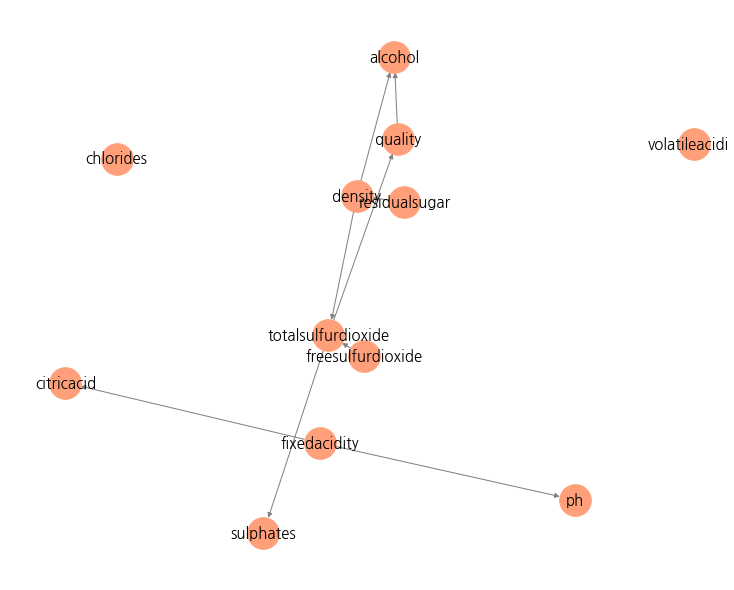

In [208]:
draw_graph(train_set, model3)